In [1]:
import os, sys
sys.path.append("../src")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,"
from pathlib import Path
from types import SimpleNamespace
from tqdm import tqdm
import math, json, io, textwrap
from omegaconf import OmegaConf
import numpy as np
import matplotlib.pyplot as plt
import lovely_tensors as lt
from einops import rearrange
from PIL import Image, ImageDraw, ImageOps
import torch
lt.monkey_patch()
from safetensors.torch import load_file, save_file

from musubi_tuner.networks import lora_framepack
from musubi_tuner.frame_pack.framepack_utils import load_vae, load_text_encoder1, load_text_encoder2, load_image_encoders
from musubi_tuner.frame_pack.hunyuan import vae_decode, vae_encode
from musubi_tuner.frame_pack.hunyuan_video_packed import load_packed_model, attn_cache
from musubi_tuner.hv_train_network import collator_class, load_prompts
from musubi_tuner.frame_pack.k_diffusion_hunyuan import sample_hunyuan
from musubi_tuner.utils.bbox_utils import get_bbox_from_mask, get_mask_from_bboxes, draw_bboxes, get_facebbox_from_bbox
from musubi_tuner.wan_generate_video import merge_lora_weights
from musubi_tuner.utils.preproc_utils import preproc_image, preproc_mask, postproc_imgs
from preproc_utils import get_text_preproc, prepare_control_inputs_for_entity, get_all_kwargs_from_opens2v_metapath
from attn_utils import get_pltplot_as_pil, get_text_inds_from_dict, get_attn_map
from viz_utils import printable_metadata, return_total_visualization

# sys.path.append("/home/yo564250/workspace/whisperer/utils")
# from img_utils import convert_from_qwen2vl_format
# from vistory_utils import StoryDataset

# vistory_dataset_path = Path("/groups/chenchen/patrick/ViStoryBench/ViStoryBench")
# vistory_dataset = StoryDataset(vistory_dataset_path)

device = torch.device('cuda')

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.
INFO:root:Xformers is not installed!
INFO:root:Flash Attn is installed!
INFO:root:Sage Attn is installed!


Trying to import sageattention
Successfully imported sageattention


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0
Device set to use cuda:0


In [2]:
# main_path = Path("/projects/bffz/ykwon4/ComfyUI/models")
main_path = Path("/lustre/fs1/home/yo564250/workspace/ComfyUI/models")
dit_path = "diffusion_models/FramePackI2V_HY_bf16.safetensors"
vae_path = "vae/hunyuan-video-t2v-720p-vae.pt"
text_encoder1_path = "text_encoders/llava_llama3_fp16.safetensors"
text_encoder2_path = "text_encoders/clip_l.safetensors"
image_encoder_path = "clip_vision/sigclip_vision_patch14_384.safetensors"
# lora_path = "/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/outputs/training/idmask_control_lora/idmask_control_lora_test3.safetensors"
# lora_path = '../../outputs/training/idmask_control_lora/idmask_control_lora_test3.safetensors'
lora_path = '../../outputs/training/idmask_control_lora_wrope_v2/idmask_control_lora_wrope_v2_1-step00006000.safetensors'
# lora_path = str(main_path / 'loras/idmask_control_lora_wrope_v2_1-step00006000.safetensors')
# lora_path = None

model = load_packed_model(device, main_path / dit_path, 'sageattn', device, has_image_proj=False)
model.to(device)
model.eval().requires_grad_(False)

if lora_path is not None:
    merge_lora_weights(lora_framepack, model, 
        SimpleNamespace(
            lora_weight = [lora_path], lora_multiplier = [1.0], 
            include_patterns=None, exclude_patterns=None, lycoris=None, save_merged_model=False
        ), 
    device, None)

vae = load_vae(str(main_path / vae_path), 32, 128, device)

tokenizer1, text_encoder1 = load_text_encoder1(SimpleNamespace(text_encoder1=str(main_path / text_encoder1_path)), False, device)
tokenizer2, text_encoder2 = load_text_encoder2(SimpleNamespace(text_encoder2=str(main_path / text_encoder2_path)))
feature_extractor, image_encoder = load_image_encoders(SimpleNamespace(image_encoder=str(main_path / image_encoder_path)))

INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Creating HunyuanVideoTransformer3DModelPacked
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Image Projection: False
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loading DiT model from /lustre/fs1/home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, device=cuda
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loaded DiT model from /lustre/fs1/home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, info=_IncompatibleKeys(missing_keys=[], unexpected_keys=['image_projection.down.bias', 'image_projection.down.weight', 'image_projection.up.bias', 'image_projection.up.weight'])
INFO:musubi_tuner.wan_generate_video:Loading LoRA weights from ../../outputs/training/idmask_control_lora_wrope_v2/idmask_control_lora_wrope_v2_1-step00006000.safetensors with multiplier 1.0
INFO:musubi_tuner.networks.lora:create LoRA network from weights
INFO:musubi_tuner.networks.lora:cre

In [ ]:
prompt = 'An anime-style girl wearing a school uniform and ribbon tie is walking along the seaside from a distance.'
height, width = 480, 480

entity_prompts = ["An anime-style girl wearing a school uniform and ribbon tie"]
entity_bboxes = [[ 0.6, 0.1, 1.0, 1.0 ]]

control_image_paths = ["../../docs/fg_sample.jpg"]
target_index = [3]
control_indices = [0]

text_kwargs = get_text_preproc(prompt, 
    text_encoder1, text_encoder2, tokenizer1, tokenizer2, 
    entity_prompts=[], device=device)

entitymask_nps = [get_mask_from_bboxes(entity_bboxes, width, height)]
entity_masks = torch.cat([preproc_mask(e_mask, width, height, invert=False)[0] for e_mask in entitymask_nps], 1)
control_kwargs, control_nps = prepare_control_inputs_for_entity(
    control_image_paths, entity_bboxes, width, height, vae,
    c_width=360, c_height=None, face_entity_bboxes=None,
    control_indices=control_indices, latent_indices=target_index, 
    adjust_custom_wh=True, mode="provided_size_mid_x", 
    use_rembg=False, print_res=True)

num_inference_steps=25
seed = np.random.randint(2**31)
generator = torch.Generator(device="cpu")
generator.manual_seed(seed)

total_kwargs = {
    'prompt': prompt, 'sampler': 'unipc', 'width': width, 'height': height, 'frames': 1, 'batch_size': 1,
    'real_guidance_scale': 1.0, 'distilled_guidance_scale': 10.0, 'guidance_rescale': 0.0, 'shift': None,
    'num_inference_step': num_inference_steps, 'generator': generator,
    'device': device, 'dtype': torch.bfloat16,
    'cache_results': True, 'cache_layers': [], 'use_attention_masking': ['mask_control'],
    'entity_masks': entity_masks,
}
attn_cache.clear()
results = sample_hunyuan(transformer=model, **total_kwargs, **text_kwargs, **control_kwargs,)

result_img = Image.fromarray(postproc_imgs(results,vae)[0])
result_img = draw_bboxes(result_img, entity_bboxes)
# result_img = draw_bboxes(result_img, control_kwargs['clean_latent_bboxes'].numpy()[0], color=(0,0,255))

mask = Image.fromarray(entitymask_nps[0]).convert("RGB")
mask = np.asarray(draw_bboxes(mask, control_kwargs['clean_latent_bboxes'][0]))
meta_str = printable_metadata(total_kwargs, text_kwargs, control_kwargs, lora_path, maxlen=80)
attn_mask = get_pltplot_as_pil(attn_cache['attn_mask'][0], vmin=-9999., vmax=0., cmap=plt.cm.viridis)
result_img = return_total_visualization('anime_test1', meta_str, np.asarray(result_img), 
                                        attn_mask, control_nps[0], mask, 
                                        np.zeros((height, width, 3), dtype=np.uint8))
result_img

Control image 0 (/lustre/fs1/groups/chenchen/patrick/OpenS2V-Nexus/datasets/test3_2/zYwOTomP5EE_segment_59_step1-12-125_step2-12-113_step4_step5_step6/source_facecrop_0.png)
  Original size: (97, 125), Processed size: (160, 206)
 Entity bbox: [0.425, 0.19117647058823528, 0.5916666666666667, 0.6911764705882353], Face bbox : [0.425, 0.19117647058823528, 0.5916666666666667, 0.5698529411764706]


  0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Activate Attention Caching for Exp.
INFO:root:1000.0: hidden_states: tensor[1, 2170, 3072] bf16 n=6666240 (13Mb) x∈[-14.625, 13.250] μ=-0.013 σ=0.641 cuda:0
INFO:root:1000.0: encoder_hidden_states: tensor[1, 193, 3072] bf16 n=592896 (1.1Mb) x∈[-3.648e+03, 496.000] μ=0.051 σ=11.875 cuda:0
INFO:root:1000.0: temb: tensor[1, 3072] bf16 6Kb x∈[-8.375, 19.125] μ=-0.103 σ=0.922 cuda:0
INFO:root:1000.0: attention_mask: tensor[1, 2363, 2363] bf16 n=5583769 (11Mb) x∈[0., 0.] μ=0. σ=0. -Inf! cuda:0
INFO:root:1000.0: rope_freqs: tensor[1, 2170, 256] n=555520 (2.1Mb) x∈[-1.000, 1.000] μ=0.338 σ=0.621 cuda:0
INFO:root:1000.0: defaultdict(<class 'list'>, {'rope_freqs': [tensor[1, 2040, 256] n=522240 (2.0Mb) x∈[-1.000, 1.000] μ=0.338 σ=0.621 cuda:0, tensor[1, 130, 256] n=33280 (0.1Mb) x∈[-1.000, 1.000] μ=0.336 σ=0.622 cuda:0], 'clean_latents': [(0, 130)], 'noise': [(130, 2170)], 'text_embeddings': [(2170, 2362), (2362, 2363)]})


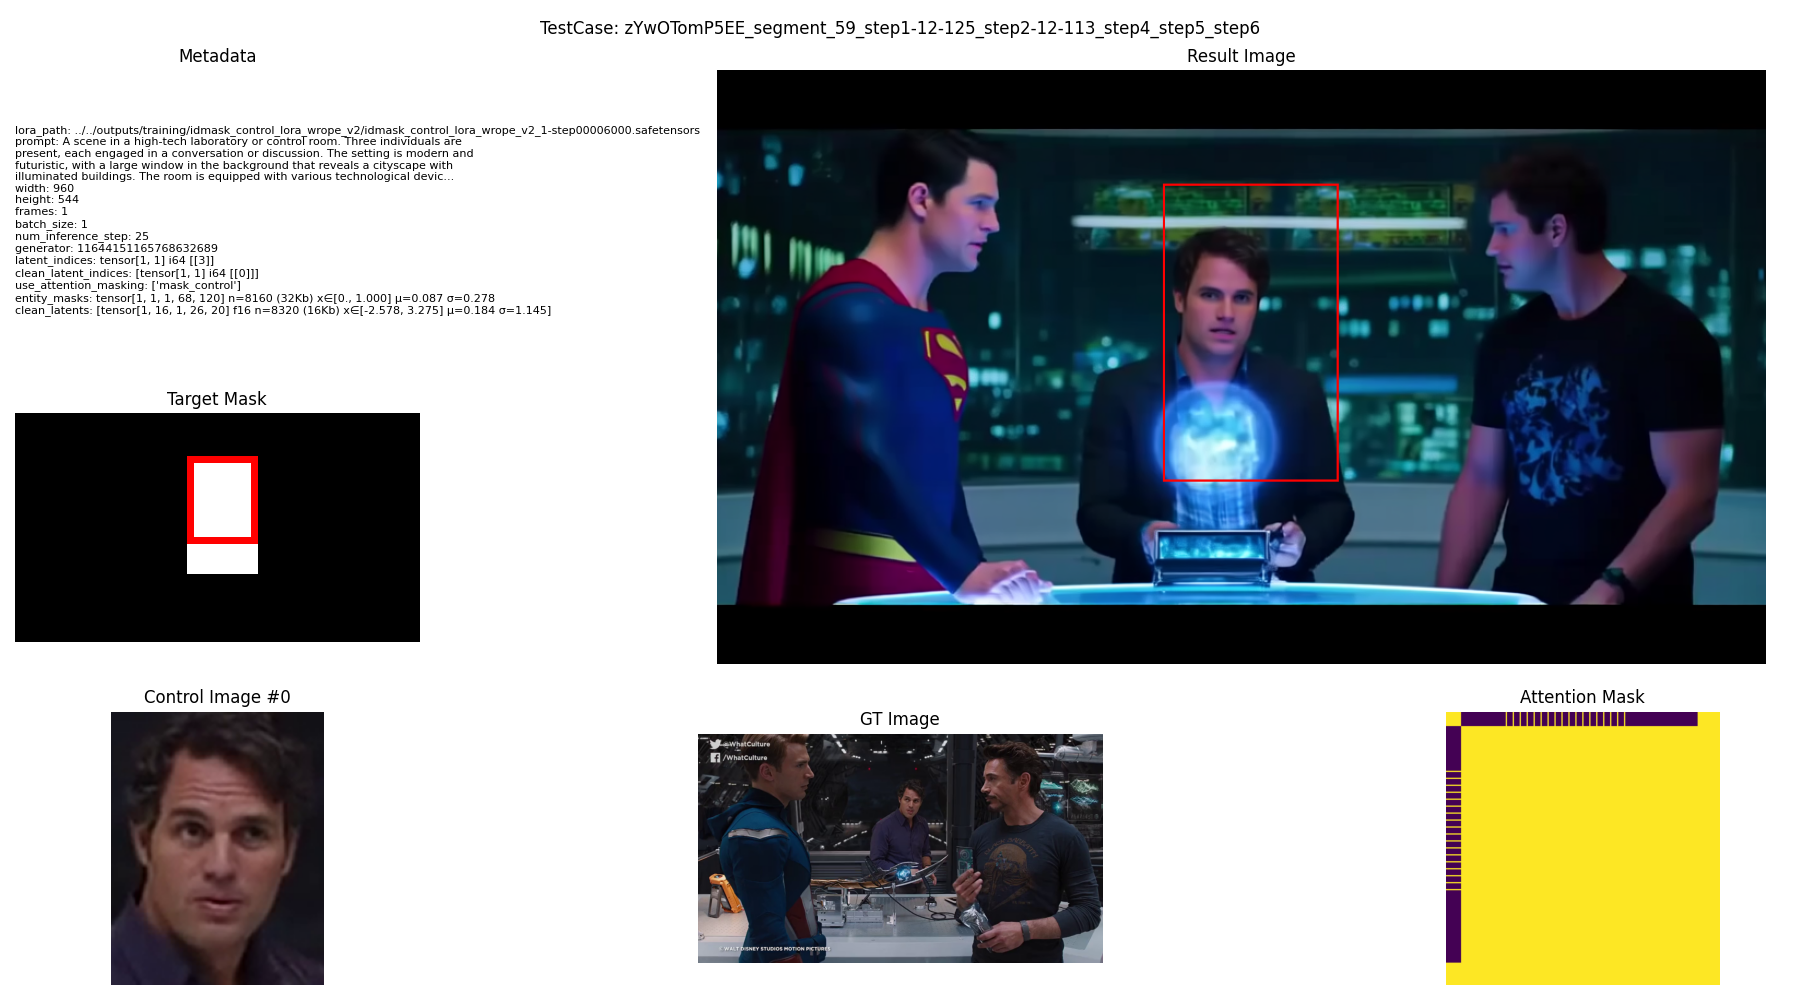

In [8]:
# dset_path = Path("/projects/bffz/ykwon4/OpenS2V-Nexus/")
dset_path = Path("/lustre/fs1/groups/chenchen/patrick/OpenS2V-Nexus/datasets")
dset_name = "test3_2"
# dset_name = "test3_part2"
# name = "RH9DTExtz1s_segment_55_step1-0-73_step2-0-73_step4_step5_step6"
name = "zYwOTomP5EE_segment_59_step1-12-125_step2-12-113_step4_step5_step6"
# name = "qo_3QHD9gYQ_segment_4_step1-0-173_step2-0-173_step4_step5_step6"
el_path = dset_path / f"{dset_name}/{name}"

width, height = 960, 544
seed = -1
total_kwargs, total_nps = get_all_kwargs_from_opens2v_metapath(
    el_path, steps=25, seed=seed, width=width, height=height, 
)
text_kwargs = get_text_preproc(
    total_kwargs['prompt'], text_encoder1, text_encoder2, tokenizer1, tokenizer2, 
    entity_prompts=[""], device=device)

control_kwargs, control_nps = prepare_control_inputs_for_entity(
    total_kwargs['control_image_paths'], total_nps['bboxes'], width, height, vae,
    c_width=None, c_height=None, face_entity_bboxes=None,
    control_indices=[0], latent_indices=[3], 
    adjust_custom_wh=True, mode="provided_size_mid_x", 
    use_rembg=False, print_res=True)

attn_cache.clear()
results = sample_hunyuan(transformer=model, **total_kwargs, **text_kwargs, **control_kwargs,)
result_img = draw_bboxes(Image.fromarray(postproc_imgs(results, vae)[0]), total_nps['bboxes'])

mask = Image.fromarray(total_nps['entitymask_nps'][0]).convert("RGB")
mask = np.asarray(draw_bboxes(mask, control_kwargs['clean_latent_bboxes'][0]))
meta_str = printable_metadata(total_kwargs, text_kwargs, control_kwargs, lora_path, maxlen=80)
attn_mask = get_pltplot_as_pil(attn_cache['attn_mask'][0], vmin=-9999., vmax=0., cmap=plt.cm.viridis)
result_img = return_total_visualization(
    name, meta_str, np.asarray(result_img), 
    attn_mask, control_nps[0], mask, total_nps['gt_np'])
result_img

In [3]:
# sys.path.append("/projects/bffz/ykwon4/vistorybench/")
sys.path.append("/lustre/fs1/home/yo564250/workspace/whisperer/datasets/storyviz/vistorybench")
from vistorybench.data_process.dataset_process.dataset_load import StoryDataset

# vistory_dataset_path = Path('/projects/bffz/ykwon4/vistorybench/data/dataset/ViStory')
vistory_dataset_path = Path('/groups/chenchen/patrick/ViStoryBench/dataset/ViStory')
vistory_dataset = StoryDataset(vistory_dataset_path)

In [4]:
story_num = '06'
shot_num = 3

story = vistory_dataset.load_story(story_num)
story_dict = {x['index']:x for x in story['shots']}
characters = vistory_dataset.load_characters(story_num)
story_shot = story_dict[shot_num]
characters_shot = {k: characters[k] for k in story_shot['character_name']}

author_output_dir = sorted(list(vistory_dataset_path.glob(f"{story_num}/gen_layouts/*")))[-1]
layout = json.loads((author_output_dir / "pose_layout.json").read_text())
panel_layout = layout[f'[PANEL-{shot_num}]']
rel_w, rel_h = panel_layout['bbox'][2] - panel_layout['bbox'][0], panel_layout['bbox'][3] - panel_layout['bbox'][1]
body_layout = [list(map(lambda a: a/1000, x[:4])) for x in panel_layout['body']]

print(panel_layout)
print(body_layout)

{'bbox': [83, 384, 388, 650], 'body': [[464, 503, 739, 918, 597, 561, 615, 602, 591, 549, 612, 551], [180, 648, 368, 924, 306, 687, 283, 721, 292, 679, 312, 679]]}
[[0.464, 0.503, 0.739, 0.918], [0.18, 0.648, 0.368, 0.924]]


In [5]:
sys.path.append("/home/yo564250/workspace/whisperer/utils/pose_detection/")
from dwpose import DwposeDetector, decode_json_as_poses
from dwpose.util import draw_bodypose
# from safetensors.torch import load_file

dwpose_model = DwposeDetector.from_pretrained(
    '/home/yo564250/workspace/ComfyUI/custom_nodes/comfyui_controlnet_aux/ckpts/hr16/DWPose-TorchScript-BatchSize5',
    '/home/yo564250/workspace/ComfyUI/custom_nodes/comfyui_controlnet_aux/ckpts/hr16/yolox-onnx',
    det_filename='yolox_l.torchscript.pt', 
    pose_filename='dw-ll_ucoco_384_bs5.torchscript.pt',
    torchscript_device='cuda:0'
)

model_path is /home/yo564250/workspace/ComfyUI/custom_nodes/comfyui_controlnet_aux/ckpts/hr16/yolox-onnx/yolox_l.torchscript.pt
model_path is /home/yo564250/workspace/ComfyUI/custom_nodes/comfyui_controlnet_aux/ckpts/hr16/DWPose-TorchScript-BatchSize5/dw-ll_ucoco_384_bs5.torchscript.pt

DWPose: Using yolox_l.torchscript.pt for bbox detection and dw-ll_ucoco_384_bs5.torchscript.pt for pose estimation
DWPose: Caching TorchScript module yolox_l.torchscript.pt on ...
DWPose: Caching TorchScript module dw-ll_ucoco_384_bs5.torchscript.pt on ...


In [ ]:
from dataclasses import dataclass
from typing import Dict, Tuple

@dataclass
class Keypoints:
    # Normalized (x,y) in [0,1]
    left_eye: Tuple[float, float]
    right_eye: Tuple[float, float]
    nose: Tuple[float, float]
    neck: Tuple[float, float]

    def to_pixels(self, width: int, height: int) -> Dict[str, np.ndarray]:
        return {
            'left_eye': np.array([self.left_eye[0] * width, self.left_eye[1] * height], dtype=float),
            'right_eye': np.array([self.right_eye[0] * width, self.right_eye[1] * height], dtype=float),
            'nose': np.array([self.nose[0] * width, self.nose[1] * height], dtype=float),
            'neck': np.array([self.neck[0] * width, self.neck[1] * height], dtype=float),
        }


In [7]:
def assemble_points(kp_dict: Dict[str, np.ndarray], use_mid_eye: bool = True) -> np.ndarray:
    pts = [
        kp_dict['left_eye'],
        kp_dict['right_eye'],
        kp_dict['nose'],
        kp_dict['neck'],
    ]
    if use_mid_eye:
        mid_eye = 0.5 * (kp_dict['left_eye'] + kp_dict['right_eye'])
        pts.append(mid_eye)
    return np.stack(pts, axis=0)  # shape (N,2)

def solve_scale_translation(src_pts: np.ndarray, tgt_pts: np.ndarray):
    """
    Least squares solution for s, t (no rotation).
    src_pts, tgt_pts: (N,2)
    Returns scale (float), translation (2,)
    """
    assert src_pts.shape == tgt_pts.shape and src_pts.ndim == 2 and src_pts.shape[1] == 2
    src_mean = src_pts.mean(axis=0)
    tgt_mean = tgt_pts.mean(axis=0)
    src_c = src_pts - src_mean
    tgt_c = tgt_pts - tgt_mean

    denom = np.sum(np.sum(src_c * src_c, axis=1))  # Σ ||X'_i||²
    if denom < 1e-8:
        scale = 1.0
    else:
        # Σ (X'_i · Y'_i)
        numer = np.sum(np.sum(src_c * tgt_c, axis=1))
        scale = numer / denom if denom > 0 else 1.0

    translation = tgt_mean - scale * src_mean
    return scale, translation  # translation is (dx, dy)

def transform_and_paste(
    source_img: Image.Image,
    scale: float,
    translation: np.ndarray,
    target_size: Tuple[int, int],
    fill_color=(0,0,0)
) -> Image.Image:
    """
    Uniformly scale source image around its origin (top-left), then translate,
    and composite onto a blank target canvas of size target_size (w,h).
    """
    tw, th = target_size
    canvas = Image.new(source_img.mode, (tw, th), fill_color)

    # Scale
    sw, sh = source_img.size
    new_w = max(1, int(round(sw * scale)))
    new_h = max(1, int(round(sh * scale)))
    scaled = source_img.resize((new_w, new_h), Image.BICUBIC)

    dx, dy = translation
    x0 = int(round(dx))
    y0 = int(round(dy))

    # Overlap calculation
    sx0, sy0 = 0, 0
    sx1, sy1 = new_w, new_h
    # Clip destination
    dx0 = max(x0, 0)
    dy0 = max(y0, 0)
    dx1 = min(x0 + new_w, tw)
    dy1 = min(y0 + new_h, th)

    if dx1 <= dx0 or dy1 <= dy0:
        return canvas  # completely out of frame

    # Corresponding source crop (if part goes outside)
    crop_left = sx0 + (dx0 - x0)
    crop_top  = sy0 + (dy0 - y0)
    crop_right = crop_left + (dx1 - dx0)
    crop_bottom = crop_top + (dy1 - dy0)

    cropped = scaled.crop((crop_left, crop_top, crop_right, crop_bottom))
    bbox = (dx0/tw, dy0/th, dx1/tw, dy1/th)
    canvas.paste(cropped, (dx0, dy0))
    return canvas, bbox

def align_source_to_target(
    source_img: Image.Image,
    source_kps: Keypoints,
    source_size: Tuple[int,int],   # (w,h) of source image (redundant but explicit)
    target_kps: Keypoints,
    target_size: Tuple[int,int],   # (w,h) of target frame
    use_mid_eye: bool = True
):
    """
    Returns:
        aligned_image (PIL.Image)
        scale (float)
        translation (np.ndarray of shape (2,))
    """
    sw, sh = source_size
    tw, th = target_size

    src_px = source_kps.to_pixels(sw, sh)
    tgt_px = target_kps.to_pixels(tw, th)

    src_pts = assemble_points(src_px, use_mid_eye=use_mid_eye)
    tgt_pts = assemble_points(tgt_px, use_mid_eye=use_mid_eye)

    scale, translation = solve_scale_translation(src_pts, tgt_pts)
    aligned, bbox = transform_and_paste(source_img, scale, translation, target_size)
    return aligned, bbox, scale, translation

DWPose: Bbox 10.28ms
DWPose: Pose 16.45ms on 1 people

(0.5270833333333333, 0.5048076923076923, 0.678125, 0.7596153846153846)


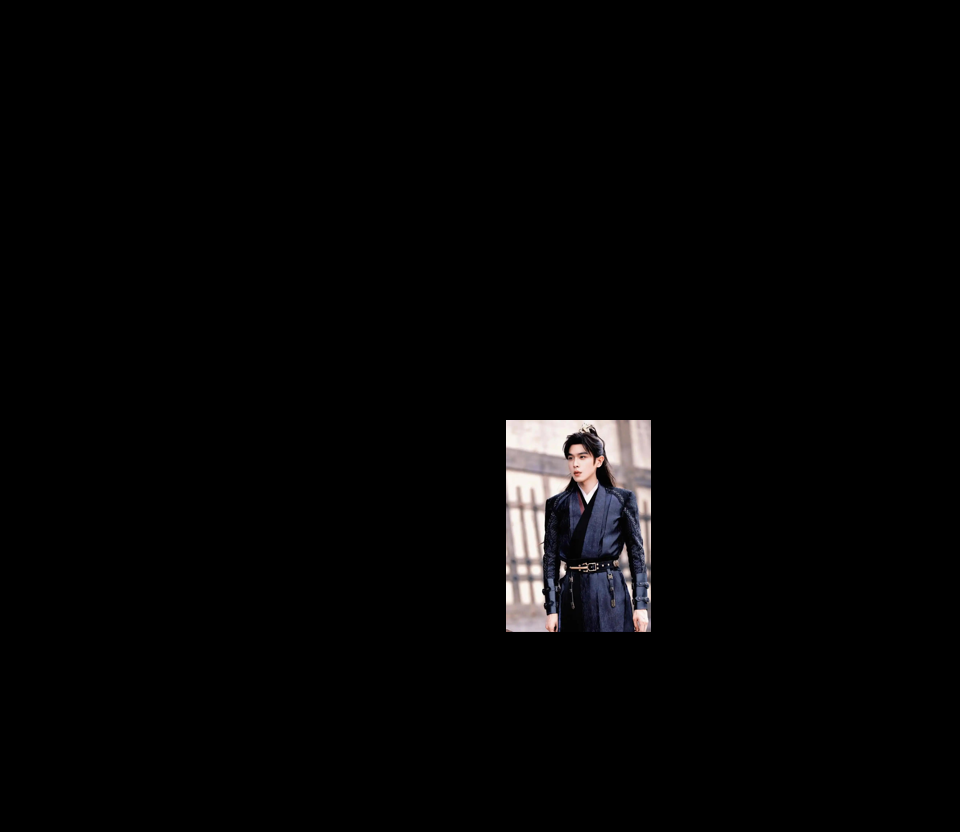

In [12]:
target_size = (960, int((960 * rel_h / rel_w) // 16 * 16))
tgt_kps = np.reshape(panel_layout['body'][0][4:], (-1,2)) / 1000.
tgt_kps = Keypoints(left_eye=tgt_kps[2], right_eye=tgt_kps[3], nose=tgt_kps[0], neck=tgt_kps[1])

source_img = Image.open(characters_shot[list(characters_shot.keys())[0]]['images'][0]).convert("RGB")
source_size = np.array(source_img.size)
out_img, out_json = dwpose_model(source_img, image_and_json=True)
src_kps = np.array(out_json['people'][0]['pose_keypoints_2d']).reshape(-1,3)[[0,1,14,15],:2]
src_kps = src_kps / source_size[None,:]
src_kps = Keypoints(left_eye=src_kps[2], right_eye=src_kps[3], nose=src_kps[0], neck=src_kps[1])

# 
aligned_img, face_bbox, scale, translation = align_source_to_target(
    source_img,
    src_kps,
    source_size,
    tgt_kps,
    target_size,
    use_mid_eye=True
)

print(face_bbox)
aligned_img

Control image 0 (/groups/chenchen/patrick/ViStoryBench/dataset/ViStory/06/image/Fan Xian/00.jpg)
  Original size: (800, 1169), Processed size: (800, 1168)
  (use background removal)
 Entity bbox: [0.464, 0.503, 0.739, 0.918], Face bbox : (0.5270833333333333, 0.5048076923076923, 0.678125, 0.7596153846153846)


  0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Activate Attention Caching for Exp.
INFO:root:1000.0: hidden_states: tensor[1, 6770, 3072] bf16 n=20797440 (40Mb) x∈[-17.500, 19.750] μ=-0.014 σ=1.469 cuda:0
INFO:root:1000.0: encoder_hidden_states: tensor[1, 44, 3072] bf16 n=135168 (0.3Mb) x∈[-1.440e+03, 378.000] μ=-0.003 σ=8.688 cuda:0
INFO:root:1000.0: temb: tensor[1, 3072] bf16 6Kb x∈[-9.062, 19.500] μ=-0.109 σ=0.941 cuda:0
INFO:root:1000.0: attention_mask: tensor[1, 6814, 6814] bf16 n=46430596 (89Mb) x∈[0., 0.] μ=0. σ=0. -Inf! cuda:0
INFO:root:1000.0: rope_freqs: tensor[1, 6770, 256] n=1733120 (6.6Mb) x∈[-1.000, 1.000] μ=0.302 σ=0.639 cuda:0
INFO:root:1000.0: defaultdict(<class 'list'>, {'rope_freqs': [tensor[1, 3120, 256] n=798720 (3.0Mb) x∈[-1.000, 1.000] μ=0.319 σ=0.631 cuda:0, tensor[1, 3650, 256] n=934400 (3.6Mb) x∈[-1.000, 1.000] μ=0.287 σ=0.646 cuda:0], 'clean_latents': [(0, 3650)], 'noise': [(3650, 6770)], 'text_embeddings': [(6770, 6814)]})
/lustre/fs1/home/yo564250/workspace/whisperer/related/framepackbase/musu

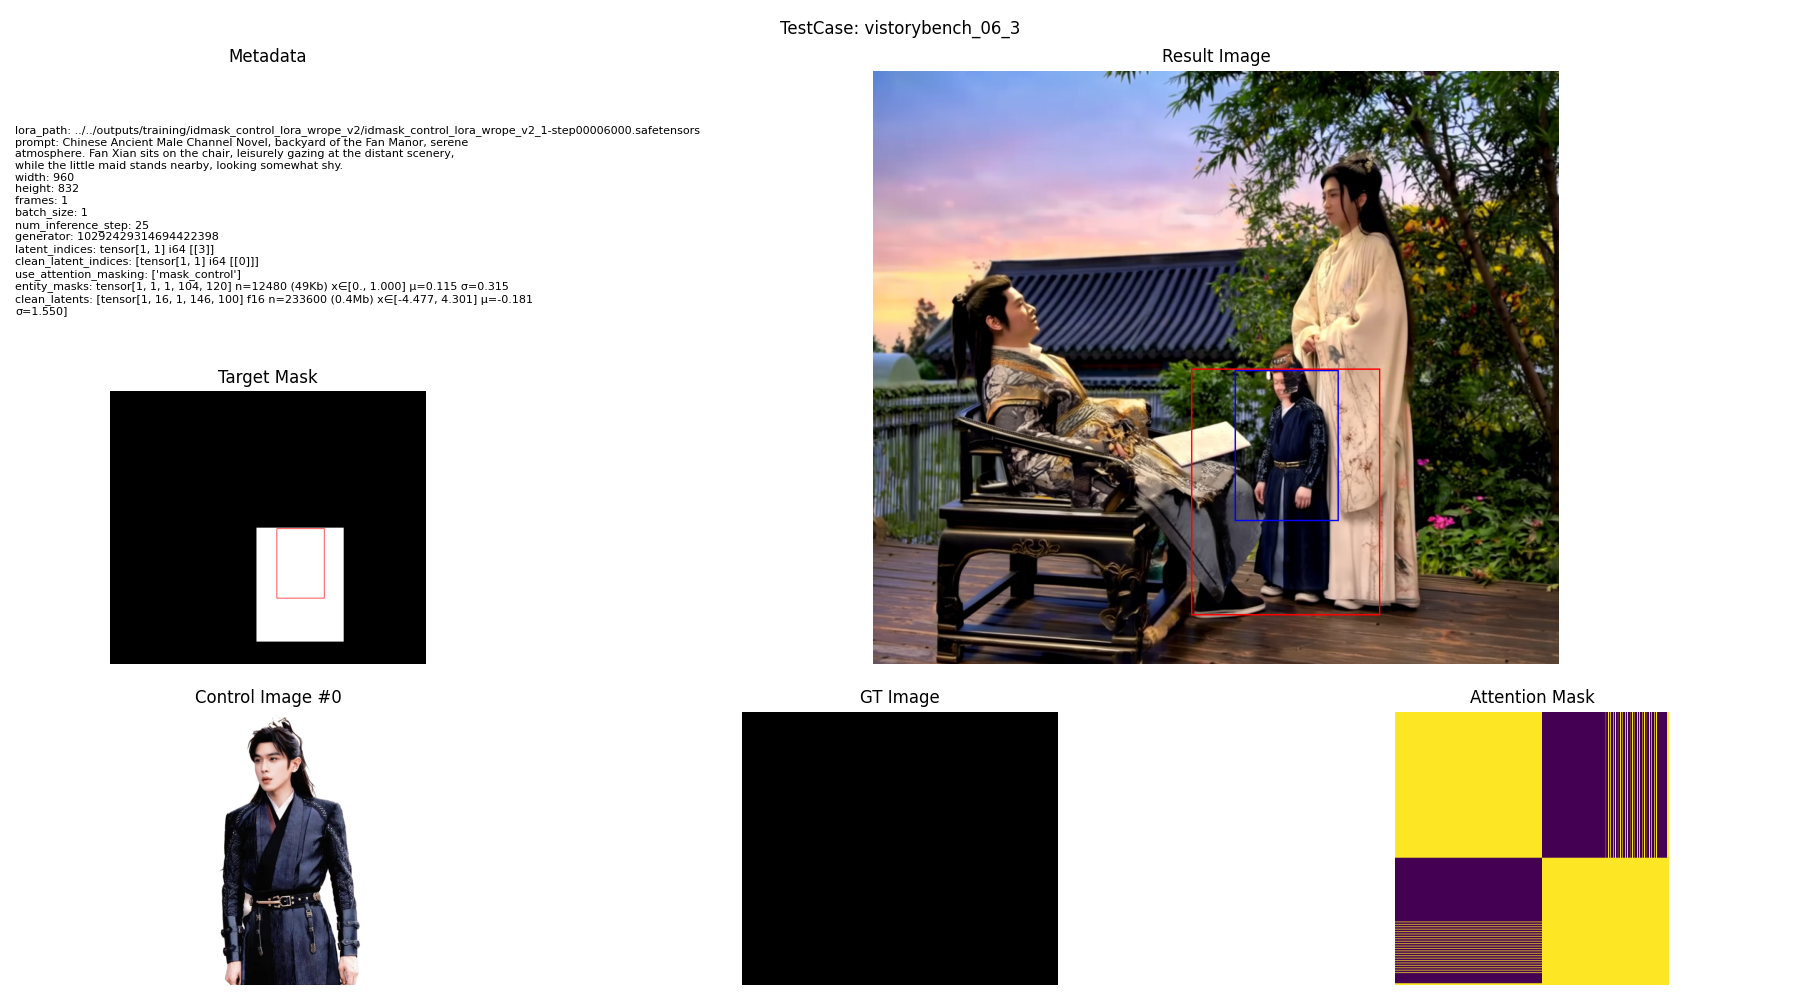

In [ ]:
style = f"{story['type']}, "
prompt = style + ", ".join(story_shot['scene'].split(", ")[1:3]) + ". " + story_shot['script']
width = 960
height = int((width * rel_h / rel_w) // 16 * 16)
entity_bboxes = [body_layout[0]]
face_entity_bboxes = [face_bbox]
# entity_bboxes = [[0.5,0.2,0.8,1.0]]
control_image_paths = [characters_shot[list(characters_shot.keys())[0]]['images'][0]]
target_index = [3]
control_indices = [0]

text_kwargs = get_text_preproc(prompt, 
    text_encoder1, text_encoder2, tokenizer1, tokenizer2, 
    entity_prompts=[], device=device)

control_kwargs, control_nps = prepare_control_inputs_for_entity(
    control_image_paths, entity_bboxes, width, height, vae,
    c_width=None, c_height=None, 
    # face_entity_bboxes=None,
    face_entity_bboxes = [face_bbox],
    control_indices=control_indices, latent_indices=target_index, 
    adjust_custom_wh=False, 
    # mode="provided_size_mid_x",
    mode="provided_face_bbox",
    use_rembg=True, print_res=True)
# control_kwargs['clean_latents'] = None
# control_kwargs['clean_latent_indices'] = None

num_inference_steps=25
seed = np.random.randint(2**31)
# seed = 364289299
generator = torch.Generator(device="cpu")
generator.manual_seed(seed)
entitymask_nps = [get_mask_from_bboxes(entity_bboxes, width, height)]
entity_masks = torch.cat([preproc_mask(e_mask, width, height, invert=False)[0] for e_mask in entitymask_nps], 1)

total_kwargs = {
    'prompt': prompt, 'sampler': 'unipc', 'width': width, 'height': height, 'frames': 1, 'batch_size': 1,
    # 'real_guidance_scale': 1.0, 'distilled_guidance_scale': 10.0, 'guidance_rescale': 0.0, 'shift': None,
    'num_inference_step': num_inference_steps, 'generator': generator,
    'device': device, 'dtype': torch.bfloat16,
    'cache_results': True, 'cache_layers': [], 'use_attention_masking': ['mask_control'],
    'entity_masks': entity_masks,
}
attn_cache.clear()
results = sample_hunyuan(transformer=model, **total_kwargs, **text_kwargs, **control_kwargs,)

result_img = Image.fromarray(postproc_imgs(results,vae)[0])
result_img = draw_bboxes(result_img, entity_bboxes)
result_img = draw_bboxes(result_img, control_kwargs['clean_latent_bboxes'].numpy()[0], color=(0,0,255))

mask = Image.fromarray(entitymask_nps[0]).convert("RGB")
mask = np.asarray(draw_bboxes(mask, control_kwargs['clean_latent_bboxes'][0]))
meta_str = printable_metadata(total_kwargs, text_kwargs, control_kwargs, lora_path, maxlen=80)
attn_mask = get_pltplot_as_pil(attn_cache['attn_mask'][0], vmin=-9999., vmax=0., cmap=plt.cm.viridis)
result_img = return_total_visualization(f'vistorybench_{story_num}_{shot_num}', meta_str, np.asarray(result_img), 
                                        attn_mask, control_nps[0], mask, 
                                        np.zeros((height, width, 3), dtype=np.uint8))
result_img

In [ ]:
dset_path = Path("/groups/chenchen/patrick/OpenS2V-Nexus/datasets")
dset_name = "test3_2"
name = "-_q0rJy4izg_segment_4_step1-0-117_step2-0-117_step4_step5_step6"

text_kwargs = load_file(dset_path / f"{dset_name}_cache/{name}_fp_te.safetensors")
control_kwargs = load_file(dset_path / f"{dset_name}_cache/{name}_1280x0720_fp.safetensors")

# seed = np.random.randint(2**31)
# seed = 42
generator = torch.Generator(device="cpu")
generator.manual_seed(seed)

attn_cache.clear()
results = sample_hunyuan(
    transformer=model, sampler='unipc', width=960, height=544, frames=1, batch_size=1,
    real_guidance_scale=1.0, distilled_guidance_scale=10.0, guidance_rescale=0.0, shift=None,
    num_inference_steps=25, generator=generator, device=device, dtype=torch.bfloat16, 
    cache_results = True, cache_layers = [], 
    use_attention_masking = ["mask_control", "mask_entities"], 
    entity_masks = control_kwargs['target_latent_masks_1x68x120_float16'].unsqueeze(0).to(device, dtype=torch.float32),
    prompt_embeds = text_kwargs['llama_vec_float16'].unsqueeze(0).to(device, dtype=torch.bfloat16),
    prompt_embeds_mask = text_kwargs['llama_attention_mask'].unsqueeze(0).to(device, dtype=torch.bool),
    prompt_poolers = text_kwargs['clip_l_pooler_float32'].unsqueeze(0).to(device, dtype=torch.bfloat16),
    clean_latents = control_kwargs['latents_clean_1x68x120_float16'].unsqueeze(0).to(device, dtype=torch.bfloat16),
    clean_latent_indices = control_kwargs['clean_latent_indices_int64'].unsqueeze(0).to(device, dtype=torch.int64),
    # clean_latent_bbox = control_kwargs['clean_latent_bbox'].unsqueeze(0).to(device, dtype=torch.float32),
    clean_latents_2x = None,
    clean_latent_2x_indices = None,
    clean_latents_4x = None,
    clean_latent_4x_indices = None,
    latent_indices = control_kwargs['latent_indices_int64'].unsqueeze(0).to(device, dtype=torch.int64),
)

history_pixels = torch.cat([
    vae_decode(results[:, :, i:i + 1, :, :], vae).cpu() 
    for i in range(results.shape[2])
], dim=2)
result_imgs = postproc_imgs(history_pixels)
Image.fromarray(result_imgs[0])

In [ ]:
print(attn_cache['attn_dict'])

attn_mask = get_pltplot_as_pil(attn_cache['attn_mask'][0], vmin=-9999., vmax=0., cmap=plt.cm.gray)

timesteps = sorted(list(attn_cache['transformer_blocks.14'].keys()), reverse=False)
token_H, token_W = height // 16, width // 16
token_C = len(control_indices + target_index)

control_inds = attn_cache['attn_dict']['clean_latents']
noise_inds = attn_cache['attn_dict']['noise'][-1]
text_inds = attn_cache['attn_dict']['text_embeddings']

fig, ax = plt.subplots(len(cache_layers), 3, figsize=(18, 18))
with torch.inference_mode():
    for i, block in enumerate(cache_layers):
        attention_map = []
        for t in range(0,25,5):
            attention_prob = attn_cache[block][timesteps[t]]
            attention_prob = attention_prob[:,:,:noise_inds[1],:].to(device)
            attention_map.append(attention_prob)
        attention_map = torch.stack(attention_map, dim=0).mean(dim=0) # B A (CHW) D
        attention_map = attention_map[:,:,noise_inds[0]:noise_inds[1]].sum(1).squeeze(1).permute(0,2,1)
        attention_map = rearrange(attention_map, 'B D (H W) -> B D H W', H=token_H, W=token_W)

        control_attention_data = attention_map[0,control_inds[-1][0]:control_inds[-1][1],:,:].mean(axis=0)
        control_attention_image = get_pltplot_as_pil(control_attention_data).resize((width,height))

        entity_attention_data = attention_map[0,text_inds[-1][0]:text_inds[-1][1],:,:].mean(axis=0)
        entity_attention_image = get_pltplot_as_pil(entity_attention_data).resize((width,height))

        text_attention_data = attention_map[0,1125:1135,:,:].mean(axis=0)
        text_attention_image = get_pltplot_as_pil(text_attention_data).resize((width,height))

        ax[i, 0].set_title(f"Layer {block.split('.')[-1]} - Ref")
        ax[i, 1].set_title(f"Layer {block.split('.')[-1]} - Entity")
        ax[i, 2].set_title(f"Layer {block.split('.')[-1]} - Global corr")
        ax[i, 0].imshow(control_attention_image)
        ax[i, 1].imshow(entity_attention_image)
        ax[i, 2].imshow(text_attention_image)
        ax[i, 0].set_xticks([])
        ax[i, 1].set_xticks([])
        ax[i, 2].set_xticks([])
        ax[i, 0].set_yticks([])
        ax[i, 1].set_yticks([])
        ax[i, 2].set_yticks([])

fig.tight_layout()
plt.show()

In [ ]:
attn_images = get_attn_map(
    {k:v for k,v in attn_cache.items() if k.startswith("transformer_blocks")}, 
    [3,24], 
    block_id=f'transformer_blocks.2', 
    token_type = 'text',
    height=height, width=width, token_C=len(control_indices + target_index),
    embed_size = 729,
    t_0=0, t_1=25)
attn_images.resize((120,120))

In [ ]:
# prompts = load_prompts('/groups/chenchen/patrick/OpenS2V-Nexus/datasets/test3_2_sample_prompts.txt')
# masks = [
#     Image.open(x).convert("L") for x in prompts[0]['entity_mask_path']
# ]
# control_images = [
#     Image.open(x).convert("RGB") for x in prompts[0]['control_image_path']
# ]
# w, h = prompts[0]['width'], prompts[0]['height']

# bbox = get_bbox_from_mask(np.array(masks[0]))

# face_bbox = get_facebbox_from_bbox(bbox, 
#     control_images[0].size[0], control_images[0].size[1], w, h, full_width=False)

# draw_bboxes(masks[0].convert("RGB"), [face_bbox])

In [ ]:
# clean_latent_bbox = control_kwargs['clean_latent_bboxes'][:,0]
# clean_H, clean_W = control_kwargs['clean_latents'][0].shape[-2:]
# clean_H, clean_W = clean_H // 2, clean_W // 2

# b = 0
# W, H = width // 16, height // 16
# cb = [
#     int(clean_latent_bbox[b,0]*W), int(clean_latent_bbox[b,1]*H), 
#     int(clean_latent_bbox[b,2]*W), int(clean_latent_bbox[b,3]*H)
# ]

# with torch.no_grad():
#     rope_freqs = model.rope(
#         frame_indices=control_kwargs['latent_indices'], 
#         height=H, width=W, device=device
#     )
#     cb_rope_freq = model.rope(
#         frame_indices=control_kwargs['clean_latent_indices'][0], 
#         height=cb[3], width=cb[2],
#         start_height=cb[1], start_width=cb[0],
#         step_H=(cb[3] - cb[1]) / clean_H,
#         step_W=(cb[2] - cb[0]) / clean_W,
#         device=device)
#     rope_freqs = rope_freqs.flatten(2).transpose(1, 2)
#     cb_rope_freqs = cb_rope_freq.flatten(2).transpose(1, 2)
    
# print(rope_freqs.shape)
# print(cb_rope_freqs.shape)